# Resume Relevence Model Creator

In [1]:
# The links to the dataset can be found here:
# https://www.kaggle.com/datasets/jillanisofttech/updated-resume-dataset
# https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset
# https://www.kaggle.com/datasets/arshkon/linkedin-job-postings

# I combined the resume-dataset and updated-resume-dataset into resumes.csv.

In [2]:
%load_ext memory_profiler
%memit
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
import logging
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import ssl
import nltk
import hashlib
import json
import time
import matplotlib.pyplot as plt

peak memory: 70.72 MiB, increment: 0.27 MiB


In [3]:
%%memit
postings = pd.read_csv("data/400_postings.csv")
resumes = pd.read_csv("data/250_resumes.csv")
display(postings)
display(resumes)

,description
0,Job descriptionA leading real estate firm in N...
1,"At Aspen Therapy and Wellness , we are committ..."
2,The National Exemplar is accepting application...
3,Senior Associate Attorney - Elder Law / Trusts...
4,Looking for HVAC service tech with experience ...
...,...
395,Fundraising Events CoordinatorReports to: Deve...
396,Job Title: Bilingual Legal Assistant/Paralegal...
397,Exciting Opportunity Alert! Discover your next...
398,Company Description\n SEOGidi is a Search Engi...


,Resume,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR
...,...,...
245,"Sure, I'd be happy to help you create a profes...",NaN
246,"Sure, I'd be happy to help you create a profes...",NaN
247,"Sure, I'd be happy to help you create a profes...",NaN
248,"Sure, I'd be happy to help you create a profes...",NaN


peak memory: 642.58 MiB, increment: 15.11 MiB


## Create Labels by reading Cache from file

In [4]:
%%memit
if os.path.exists('data/100K_multi_cache.json'):
	with open('data/100K_multi_cache.json', 'r') as cache_file:
		cache = json.load(cache_file)
else:
	print("ERROR: Could not find cache. Aborting")
	sys.exit(1)


labels = []
for job_description in postings['description']:
	for resume_text in resumes['Resume']:
		key = hashlib.md5(f"{resume_text}{job_description}".encode()).hexdigest()
		relevance = cache.get(key)
		if relevance == None:
			print(f"ERROR: COULD NOT FIND LABEL FOR KEY {key}. THIS SHOULD BE ADDRESSED. DEFAULTING TO 0")
			relevance = 0
		labels.append(relevance)

print(labels)

[2, 3, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 3, 0, 0, 0, 3, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 3, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 3, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 3, 2, 0, 3, 3, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 2, 0, 3, 2, 2, 4, 0, 3, 0, 3, 3, 0, 0, 2, 3, 3, 3, 0, 2, 0, 0, 3, 0, 4, 2, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 3, 2, 0, 0, 0, 0, 0, 2, 3, 2, 3, 3, 2, 0, 2, 2, 0, 0, 3, 4, 4, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 4, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 0, 2, 3, 3, 3, 3, 0, 0, 3, 3, 3, 2, 0, 3, 0, 3, 3, 3, 3, 3, 0, 2, 2, 3, 2, 0, 2, 3, 3, 2, 3, 0, 2, 0, 2, 2, 0, 3, 4, 2, 0, 3, 0, 4, 4, 0, 3, 2, 0, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 3, 0, 3, 0, 3, 2, 0, 0, 3, 0, 

## Preprocess then Vectorize text

In [5]:
%%memit

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text_series):
    logging.info("Preprocessing text...")
    text_series = text_series.fillna("")  # Replace NaN with empty strings
    text_series = text_series.apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text_series = text_series.apply(lambda x: ' '.join(
        lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words
    ))
    return text_series

resumes['Resume'] = preprocess_text(resumes['Resume'])
postings['description'] = preprocess_text(postings['description'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/armandrismir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/armandrismir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


peak memory: 741.14 MiB, increment: 79.14 MiB


In [6]:
%%memit
universal_sentence_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def vectorize_text(text_series):
    logging.info("Vectorizing text...")
    embeddings = universal_sentence_encoder(text_series.tolist()).numpy()
    return embeddings

vectorized_resumes = vectorize_text(resumes['Resume'])
vectorized_postings = vectorize_text(postings['description'])

peak memory: 1389.28 MiB, increment: 648.14 MiB


## Create Resume, Posting vector pairs

In [7]:
%%memit
resume_posting_pairs = [(vectorized_resumes[i], vectorized_postings[j])
                for i in range(len(resumes)) for j in range(len(postings))]
# Ensure vector pairs are numpy arrays
resume_posting_pairs = [(np.array(left), np.array(right)) for left, right in resume_posting_pairs]

peak memory: 1726.64 MiB, increment: 149.16 MiB


## Train a ML Model using Vector pairs and Labels

In [8]:
device = torch.device('cpu')
train_pairs, test_pairs, train_labels, test_labels = train_test_split(resume_posting_pairs, labels, test_size=0.05, random_state=42)

train_left = np.array([x[0] for x in train_pairs])
train_right = np.array([x[1] for x in train_pairs])
test_left = np.array([x[0] for x in test_pairs])
test_right = np.array([x[1] for x in test_pairs])

train_data = (torch.tensor(train_left, dtype=torch.float32), torch.tensor(train_right, dtype=torch.float32))
test_data = (torch.tensor(test_left, dtype=torch.float32), torch.tensor(test_right, dtype=torch.float32))

train_labels = torch.tensor(train_labels, dtype=torch.long)  # Convert to LongTensor for CrossEntropyLoss
test_labels = torch.tensor(test_labels, dtype=torch.long)

class SiameseNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SiameseNetwork, self).__init__()
        self.shared_network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(64, num_classes)  # Output layer with num_classes nodes

    def forward_one_side(self, x):
        return self.shared_network(x)

    def forward(self, input1, input2):
        output1 = self.forward_one_side(input1)
        output2 = self.forward_one_side(input2)
        distance = torch.abs(output1 - output2)
        output = self.output_layer(distance)
        return output

input_size = train_left.shape[1]
num_classes = 5  # Labels range from 0 to 4

model = SiameseNetwork(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop (similar to before)
early_stopping_patience = 10
num_epochs = 50
batch_size = 8

train_dataset = torch.utils.data.TensorDataset(train_data[0], train_data[1], train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(test_data[0], test_data[1], test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
patience_counter = 0

class_counts = torch.bincount(train_labels)
class_weights = 1. / class_counts.float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

# Update criterion with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

logging.info("Starting model training...")
print("Starting model training...")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (left, right, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(left.to(device), right.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (left, right, labels) in enumerate(test_loader):
            outputs = model(left.to(device), right.to(device))
            loss = criterion(outputs, labels.to(device))
            val_loss += loss.item()

    val_loss /= len(test_loader)

    logging.info(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '100K_siamese_network.pth')
        print("Model saved.")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load('100K_siamese_network.pth', map_location=device))
print("Best model loaded.")


Starting model training...
Epoch 1/50, Train Loss: 1.2896591148677625, Validation Loss: 1.2858131224632263
Model saved.
Epoch 2/50, Train Loss: 1.275368790777106, Validation Loss: 1.4017847655296325
Epoch 3/50, Train Loss: 1.2675808886778983, Validation Loss: 1.5287732937812806
Epoch 4/50, Train Loss: 1.2610736783906034, Validation Loss: 1.6839308619499207
Epoch 5/50, Train Loss: 1.2594252947757119, Validation Loss: 1.7709174696445464
Epoch 6/50, Train Loss: 1.2549508664796227, Validation Loss: 1.408782590341568
Epoch 7/50, Train Loss: 1.251026890707016, Validation Loss: 2.3523659532547
Epoch 8/50, Train Loss: 1.2463336039894506, Validation Loss: 1.736229185771942
Epoch 9/50, Train Loss: 1.2405662768213372, Validation Loss: 2.2569240898132326
Epoch 10/50, Train Loss: 1.2386316474262036, Validation Loss: 1.3954221157073974
Epoch 11/50, Train Loss: 1.234157816771457, Validation Loss: 2.858251387500763
Early stopping triggered.
Best model loaded.


/var/folders/gl/d35y1q0n1tv41dfx9xttz8fw0000gn/T/ipykernel_68798/2058037519.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('100K_siam

# Measuring the performance of the model:

In [9]:
model = SiameseNetwork(512, num_classes=5)  # Ensure num_classes matches your labels
model.load_state_dict(torch.load('100K_siamese_network.pth', map_location=device))
model.eval()

predictions = []
labels = []
loss = []

criterion = nn.CrossEntropyLoss(reduction='none')

for vec_r, vec_p, label in zip(test_data[0], test_data[1], test_labels):
	logits = model(vec_r.unsqueeze(0), vec_p.unsqueeze(0))
	probabilities = torch.softmax(logits, dim=1).squeeze(0)
	predicted_class = torch.argmax(probabilities).item()
	sample_loss = criterion(logits, label.unsqueeze(0)).item()
	# if predicted_class == label.item():
	#     print(f"Predicted: {predicted_class}, Actual: {label.item()}")
	predictions.append(predicted_class)
	labels.append(label.item())
	loss.append(sample_loss)

# Create a DataFrame to store the results
results = pd.DataFrame({
	'Prediction': predictions,
	'Labels': labels,
	'Loss': loss
})

results

/var/folders/gl/d35y1q0n1tv41dfx9xttz8fw0000gn/T/ipykernel_68798/4006420922.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('100K_siames

,Prediction,Labels,Loss
0,0,0,1.017800
1,0,0,1.139775
2,0,0,0.929815
3,0,0,1.128807
4,0,2,1.189028
...,...,...,...
4995,0,2,1.243535
4996,0,2,1.245743
4997,2,0,1.101676
4998,0,0,1.073766


We are treating this as a regression problem. <br />
Each pair gets a rating between unqualified (0) to qualified (1). <br />
We were off on average by about **15%**. <br />

In [10]:
results.describe()

,Prediction,Labels,Loss
count,5000.000000,5000.000000,5000.000000
mean,0.156400,0.674200,1.123992
std,0.538142,1.085675,0.208231
min,0.000000,0.000000,0.363635
25%,0.000000,0.000000,1.007270
50%,0.000000,0.000000,1.092211
75%,0.000000,2.000000,1.187688
max,3.000000,4.000000,5.302762


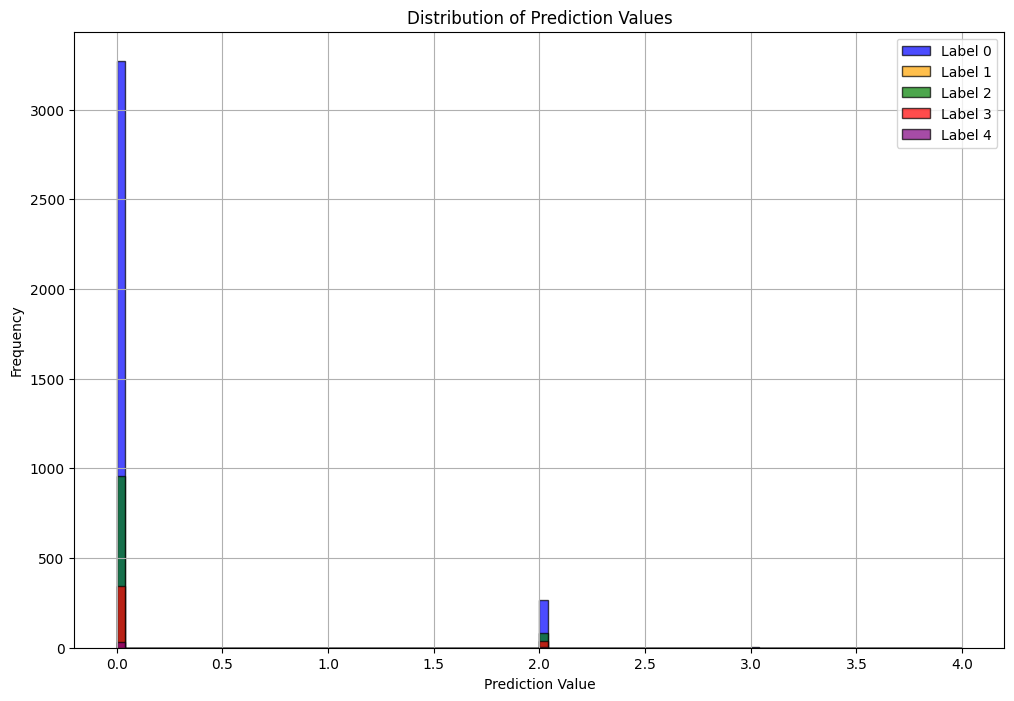

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple']
labels_range = range(5)

for i in labels_range:
    predictions_label = results[results['Labels'] == i]['Prediction']
    plt.hist(predictions_label, bins=100, edgecolor='black', alpha=0.7, 
             range=(0, 4), color=colors[i], label=f'Label {i}')

plt.title('Distribution of Prediction Values')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()
